In [1]:
!pip install transformers datasets seqeval

import os
import torch
import numpy as np
import pandas as pd
from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForTokenClassification,
    Trainer,
    TrainingArguments,
    DataCollatorForTokenClassification
)
from seqeval.metrics import precision_score, recall_score, f1_score
from shutil import rmtree

# Check GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

# Load and sample dataset
dataset = load_dataset("dell-research-harvard/newswire")["train"]
dataset = dataset.shuffle(seed=42).select(range(2000))
split = dataset.train_test_split(test_size=0.2, seed=42)
train_data, test_data = split["train"], split["test"]


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 16.8 MB/s eta 0:00:00
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16162 sha256=e159b9f1343a4d51780f42ad9942d514a8767786cca88f33b8af889c210d7dcc
  Stored in directory: /root/.cache/pip/wheels/bc/92/f0/243288f899c2eacdfa8c5f9aede4c71a9bad0ee26a01dc5ead
Successfully built seqeval
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency res

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.98k [00:00<?, ?B/s]

Resolving data files:   0%|          | 0/100 [00:00<?, ?it/s]

1880_data_clean.json:   0%|          | 0.00/26.8M [00:00<?, ?B/s]

1878_data_clean.json:   0%|          | 0.00/15.5M [00:00<?, ?B/s]

1881_data_clean.json:   0%|          | 0.00/30.9M [00:00<?, ?B/s]

1879_data_clean.json:   0%|          | 0.00/20.2M [00:00<?, ?B/s]

1882_data_clean.json:   0%|          | 0.00/29.3M [00:00<?, ?B/s]

1890_data_clean.json:   0%|          | 0.00/95.3M [00:00<?, ?B/s]

1893_data_clean.json:   0%|          | 0.00/103M [00:00<?, ?B/s]

1889_data_clean.json:   0%|          | 0.00/81.8M [00:00<?, ?B/s]

1886_data_clean.json:   0%|          | 0.00/52.4M [00:00<?, ?B/s]

1891_data_clean.json:   0%|          | 0.00/108M [00:00<?, ?B/s]

1885_data_clean.json:   0%|          | 0.00/53.1M [00:00<?, ?B/s]

1887_data_clean.json:   0%|          | 0.00/66.0M [00:00<?, ?B/s]

1888_data_clean.json:   0%|          | 0.00/63.0M [00:00<?, ?B/s]

1884_data_clean.json:   0%|          | 0.00/33.8M [00:00<?, ?B/s]

1892_data_clean.json:   0%|          | 0.00/89.7M [00:00<?, ?B/s]

1883_data_clean.json:   0%|          | 0.00/36.9M [00:00<?, ?B/s]

1894_data_clean.json:   0%|          | 0.00/113M [00:00<?, ?B/s]

1895_data_clean.json:   0%|          | 0.00/110M [00:00<?, ?B/s]

1896_data_clean.json:   0%|          | 0.00/126M [00:00<?, ?B/s]

1897_data_clean.json:   0%|          | 0.00/139M [00:00<?, ?B/s]

1898_data_clean.json:   0%|          | 0.00/147M [00:00<?, ?B/s]

1900_data_clean.json:   0%|          | 0.00/123M [00:00<?, ?B/s]

1899_data_clean.json:   0%|          | 0.00/135M [00:00<?, ?B/s]

1901_data_clean.json:   0%|          | 0.00/111M [00:00<?, ?B/s]

1902_data_clean.json:   0%|          | 0.00/110M [00:00<?, ?B/s]

1903_data_clean.json:   0%|          | 0.00/98.1M [00:00<?, ?B/s]

1904_data_clean.json:   0%|          | 0.00/106M [00:00<?, ?B/s]

1905_data_clean.json:   0%|          | 0.00/105M [00:00<?, ?B/s]

1907_data_clean.json:   0%|          | 0.00/98.2M [00:00<?, ?B/s]

1908_data_clean.json:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

1906_data_clean.json:   0%|          | 0.00/116M [00:00<?, ?B/s]

1910_data_clean.json:   0%|          | 0.00/127M [00:00<?, ?B/s]

1909_data_clean.json:   0%|          | 0.00/114M [00:00<?, ?B/s]

1911_data_clean.json:   0%|          | 0.00/110M [00:00<?, ?B/s]

1912_data_clean.json:   0%|          | 0.00/121M [00:00<?, ?B/s]

1913_data_clean.json:   0%|          | 0.00/125M [00:00<?, ?B/s]

1914_data_clean.json:   0%|          | 0.00/121M [00:00<?, ?B/s]

1915_data_clean.json:   0%|          | 0.00/120M [00:00<?, ?B/s]

1916_data_clean.json:   0%|          | 0.00/126M [00:00<?, ?B/s]

1917_data_clean.json:   0%|          | 0.00/166M [00:00<?, ?B/s]

1920_data_clean.json:   0%|          | 0.00/368M [00:00<?, ?B/s]

1919_data_clean.json:   0%|          | 0.00/171M [00:00<?, ?B/s]

1918_data_clean.json:   0%|          | 0.00/171M [00:00<?, ?B/s]

1921_data_clean.json:   0%|          | 0.00/380M [00:00<?, ?B/s]

1922_data_clean.json:   0%|          | 0.00/375M [00:00<?, ?B/s]

1923_data_clean.json:   0%|          | 0.00/381M [00:00<?, ?B/s]

1924_data_clean.json:   0%|          | 0.00/383M [00:00<?, ?B/s]

1925_data_clean.json:   0%|          | 0.00/383M [00:00<?, ?B/s]

1926_data_clean.json:   0%|          | 0.00/379M [00:00<?, ?B/s]

1927_data_clean.json:   0%|          | 0.00/390M [00:00<?, ?B/s]

1928_data_clean.json:   0%|          | 0.00/435M [00:00<?, ?B/s]

1929_data_clean.json:   0%|          | 0.00/460M [00:00<?, ?B/s]

1930_data_clean.json:   0%|          | 0.00/454M [00:00<?, ?B/s]

1931_data_clean.json:   0%|          | 0.00/442M [00:00<?, ?B/s]

1932_data_clean.json:   0%|          | 0.00/459M [00:00<?, ?B/s]

1933_data_clean.json:   0%|          | 0.00/459M [00:00<?, ?B/s]

1934_data_clean.json:   0%|          | 0.00/472M [00:00<?, ?B/s]

1935_data_clean.json:   0%|          | 0.00/461M [00:00<?, ?B/s]

1936_data_clean.json:   0%|          | 0.00/445M [00:00<?, ?B/s]

1937_data_clean.json:   0%|          | 0.00/450M [00:00<?, ?B/s]

1938_data_clean.json:   0%|          | 0.00/459M [00:00<?, ?B/s]

1939_data_clean.json:   0%|          | 0.00/454M [00:00<?, ?B/s]

1940_data_clean.json:   0%|          | 0.00/426M [00:00<?, ?B/s]

1941_data_clean.json:   0%|          | 0.00/435M [00:00<?, ?B/s]

1942_data_clean.json:   0%|          | 0.00/463M [00:00<?, ?B/s]

1944_data_clean.json:   0%|          | 0.00/516M [00:00<?, ?B/s]

1943_data_clean.json:   0%|          | 0.00/501M [00:00<?, ?B/s]

1945_data_clean.json:   0%|          | 0.00/499M [00:00<?, ?B/s]

1946_data_clean.json:   0%|          | 0.00/550M [00:00<?, ?B/s]

1947_data_clean.json:   0%|          | 0.00/540M [00:00<?, ?B/s]

1948_data_clean.json:   0%|          | 0.00/504M [00:00<?, ?B/s]

1949_data_clean.json:   0%|          | 0.00/507M [00:00<?, ?B/s]

1951_data_clean.json:   0%|          | 0.00/537M [00:00<?, ?B/s]

1950_data_clean.json:   0%|          | 0.00/517M [00:00<?, ?B/s]

1952_data_clean.json:   0%|          | 0.00/609M [00:00<?, ?B/s]

1953_data_clean.json:   0%|          | 0.00/630M [00:00<?, ?B/s]

1954_data_clean.json:   0%|          | 0.00/609M [00:00<?, ?B/s]

1955_data_clean.json:   0%|          | 0.00/604M [00:00<?, ?B/s]

1956_data_clean.json:   0%|          | 0.00/605M [00:00<?, ?B/s]

1957_data_clean.json:   0%|          | 0.00/622M [00:00<?, ?B/s]

1958_data_clean.json:   0%|          | 0.00/597M [00:00<?, ?B/s]

1959_data_clean.json:   0%|          | 0.00/604M [00:00<?, ?B/s]

1960_data_clean.json:   0%|          | 0.00/582M [00:00<?, ?B/s]

1961_data_clean.json:   0%|          | 0.00/561M [00:00<?, ?B/s]

1962_data_clean.json:   0%|          | 0.00/550M [00:00<?, ?B/s]

1963_data_clean.json:   0%|          | 0.00/557M [00:00<?, ?B/s]

1964_data_clean.json:   0%|          | 0.00/560M [00:00<?, ?B/s]

1965_data_clean.json:   0%|          | 0.00/510M [00:00<?, ?B/s]

1966_data_clean.json:   0%|          | 0.00/506M [00:00<?, ?B/s]

1967_data_clean.json:   0%|          | 0.00/502M [00:00<?, ?B/s]

1968_data_clean.json:   0%|          | 0.00/471M [00:00<?, ?B/s]

1969_data_clean.json:   0%|          | 0.00/482M [00:00<?, ?B/s]

1970_data_clean.json:   0%|          | 0.00/473M [00:00<?, ?B/s]

1971_data_clean.json:   0%|          | 0.00/463M [00:00<?, ?B/s]

1972_data_clean.json:   0%|          | 0.00/441M [00:00<?, ?B/s]

1973_data_clean.json:   0%|          | 0.00/419M [00:00<?, ?B/s]

1974_data_clean.json:   0%|          | 0.00/421M [00:00<?, ?B/s]

1975_data_clean.json:   0%|          | 0.00/423M [00:00<?, ?B/s]

1976_data_clean.json:   0%|          | 0.00/390M [00:00<?, ?B/s]

1977_data_clean.json:   0%|          | 0.00/364M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Loading dataset shards:   0%|          | 0/23 [00:00<?, ?it/s]


>>> dbmdz/bert-large-cased-finetuned-conll03-english | epochs=1


tokenizer_config.json:   0%|          | 0.00/60.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/998 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.33G [00:00<?, ?B/s]

Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Map:   0%|          | 0/1600 [00:00<?, ? examples/s]

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

<timed exec>:97: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.


Step,Training Loss


F1: 0.7999518825935281

>>> dbmdz/bert-large-cased-finetuned-conll03-english | epochs=2


Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

<timed exec>:97: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.


Step,Training Loss


F1: 0.8394098280697476

>>> dbmdz/bert-large-cased-finetuned-conll03-english | epochs=5


Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
<timed exec>:97: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.


Step,Training Loss


F1: 0.8604537692120029

>>> dbmdz/bert-large-cased-finetuned-conll03-english | epochs=10


Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
<timed exec>:97: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.


Step,Training Loss


F1: 0.8661705502012932

>>> Jean-Baptiste/roberta-large-ner-english | epochs=1


tokenizer_config.json:   0%|          | 0.00/255 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/849 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at Jean-Baptiste/roberta-large-ner-english and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([5]) in the checkpoint and torch.Size([9]) in the model instantiated
- classifier.weight: found shape torch.Size([5, 1024]) in the checkpoint and torch.Size([9, 1024]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/1600 [00:00<?, ? examples/s]

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

<timed exec>:97: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.


Step,Training Loss


F1: 0.8726448843310279

>>> Jean-Baptiste/roberta-large-ner-english | epochs=2


Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at Jean-Baptiste/roberta-large-ner-english and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([5]) in the checkpoint and torch.Size([9]) in the model instantiated
- classifier.weight: found shape torch.Size([5, 1024]) in the checkpoint and torch.Size([9, 1024]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

<timed exec>:97: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.


Step,Training Loss


F1: 0.8799524092801904

>>> Jean-Baptiste/roberta-large-ner-english | epochs=5


Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at Jean-Baptiste/roberta-large-ner-english and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([5]) in the checkpoint and torch.Size([9]) in the model instantiated
- classifier.weight: found shape torch.Size([5, 1024]) in the checkpoint and torch.Size([9, 1024]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<timed exec>:97: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.


Step,Training Loss


F1: 0.8964447625864949

>>> Jean-Baptiste/roberta-large-ner-english | epochs=10


Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at Jean-Baptiste/roberta-large-ner-english and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([5]) in the checkpoint and torch.Size([9]) in the model instantiated
- classifier.weight: found shape torch.Size([5, 1024]) in the checkpoint and torch.Size([9, 1024]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<timed exec>:97: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.


Step,Training Loss


F1: 0.8936220847215611

>>> elastic/distilbert-base-uncased-finetuned-conll03-english | epochs=1


tokenizer_config.json:   0%|          | 0.00/258 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/904 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/265M [00:00<?, ?B/s]

Map:   0%|          | 0/1600 [00:00<?, ? examples/s]

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

<timed exec>:97: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.


Step,Training Loss


F1: 0.7335779382175406

>>> elastic/distilbert-base-uncased-finetuned-conll03-english | epochs=2


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

<timed exec>:97: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.


Step,Training Loss


F1: 0.770970782280867

>>> elastic/distilbert-base-uncased-finetuned-conll03-english | epochs=5


<timed exec>:97: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.


Step,Training Loss


F1: 0.7988228369629194

>>> elastic/distilbert-base-uncased-finetuned-conll03-english | epochs=10


<timed exec>:97: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.


Step,Training Loss


F1: 0.8126692570352054

>>> dell-research-harvard/historical_newspaper_ner | epochs=1


tokenizer_config.json:   0%|          | 0.00/1.34k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/999k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/957 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.03k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Map:   0%|          | 0/1600 [00:00<?, ? examples/s]

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

<timed exec>:97: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.


Step,Training Loss


F1: 0.8655452299729444

>>> dell-research-harvard/historical_newspaper_ner | epochs=2


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

<timed exec>:97: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.


Step,Training Loss


F1: 0.8921685313020709

>>> dell-research-harvard/historical_newspaper_ner | epochs=5


<timed exec>:97: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.


Step,Training Loss


F1: 0.9018251222712632

>>> dell-research-harvard/historical_newspaper_ner | epochs=10


<timed exec>:97: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.


Step,Training Loss


F1: 0.894361170592434
                                                model  batch_size  epochs  \
6             Jean-Baptiste/roberta-large-ner-english           8       5   
7             Jean-Baptiste/roberta-large-ner-english           8      10   
5             Jean-Baptiste/roberta-large-ner-english           8       2   
4             Jean-Baptiste/roberta-large-ner-english           8       1   
3    dbmdz/bert-large-cased-finetuned-conll03-english           8      10   
2    dbmdz/bert-large-cased-finetuned-conll03-english           8       5   
1    dbmdz/bert-large-cased-finetuned-conll03-english           8       2   
0    dbmdz/bert-large-cased-finetuned-conll03-english           8       1   
14     dell-research-harvard/historical_newspaper_ner           8       5   
15     dell-research-harvard/historical_newspaper_ner           8      10   
13     dell-research-harvard/historical_newspaper_ner           8       2   
12     dell-research-harvard/historical_newspaper_ner 

<Figure size 800x500 with 0 Axes>

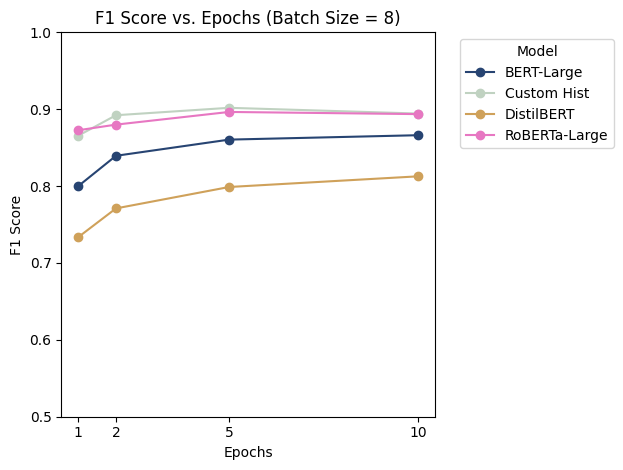

CPU times: user 23min 21s, sys: 15.9 s, total: 23min 37s
Wall time: 23min 23s


In [2]:
%%time

# Label mappings
label_names = ["O","B-PER","I-PER","B-ORG","I-ORG","B-LOC","I-LOC","B-MISC","I-MISC"]
label2id = {l:i for i,l in enumerate(label_names)}
id2label = {i:l for l,i in label2id.items()}

# Tokenize and align labels
def tokenize_and_align_labels(examples, tokenizer):
    tokenized = tokenizer(
        examples["ner_words"],
        is_split_into_words=True,
        truncation=True,
        padding="max_length",
        max_length=128
    )
    aligned = []
    for i, labels in enumerate(examples["ner_labels"]):
        word_ids = tokenized.word_ids(batch_index=i)
        prev = None; lab_ids = []
        for wid in word_ids:
            if wid is None:
                lab_ids.append(-100)
            elif wid != prev:
                lab_ids.append(label2id[labels[wid]])
            else:
                lbl = labels[wid]
                if lbl.startswith("B-"):
                    lbl = "I-" + lbl.split("-",1)[1]
                lab_ids.append(label2id[lbl])
            prev = wid
        aligned.append(lab_ids)
    tokenized["labels"] = aligned
    return tokenized

# Evaluation metrics
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=2)
    true_labels, pred_labels = [], []
    for labs, ps in zip(labels, preds):
        t, p = [], []
        for l, pr in zip(labs, ps):
            if l != -100:
                t.append(id2label[l]); p.append(id2label[pr])
        true_labels.append(t); pred_labels.append(p)
    return {
        "precision": precision_score(true_labels, pred_labels),
        "recall":    recall_score(true_labels, pred_labels),
        "f1":        f1_score(true_labels, pred_labels)
    }

# Model list and fixed batch size
models = [
    "dbmdz/bert-large-cased-finetuned-conll03-english",
    "Jean-Baptiste/roberta-large-ner-english",
    "elastic/distilbert-base-uncased-finetuned-conll03-english",
    "dell-research-harvard/historical_newspaper_ner"
]
epoch_choices = [1, 2, 5, 10]
fixed_batch_size = 8

results = []

# Training and evaluation loop
for model_name in models:
    for epochs in epoch_choices:
        print(f"\n>>> {model_name} | epochs={epochs}")

        # Load tokenizer and model
        tok = AutoTokenizer.from_pretrained(model_name, add_prefix_space=True)
        model = AutoModelForTokenClassification.from_pretrained(
            model_name,
            num_labels=len(label_names),
            id2label=id2label,
            label2id=label2id,
            ignore_mismatched_sizes=True
        ).to(device)

        # Tokenize data
        train_tok = train_data.map(lambda x: tokenize_and_align_labels(x, tok), batched=True)
        eval_tok  = test_data.map( lambda x: tokenize_and_align_labels(x, tok), batched=True)
        collator = DataCollatorForTokenClassification(tok)

        # Training arguments
        args = TrainingArguments(
            output_dir="./tmp",
            per_device_train_batch_size=fixed_batch_size,
            per_device_eval_batch_size=fixed_batch_size,
            num_train_epochs=epochs,
            learning_rate=2e-5,
            weight_decay=0.01,
            logging_steps=5000,
            save_strategy="no",
            fp16=(device=="cuda"),
            report_to=[]
        )

        trainer = Trainer(
            model=model, args=args,
            train_dataset=train_tok,
            eval_dataset=eval_tok,
            tokenizer=tok,
            data_collator=collator,
            compute_metrics=compute_metrics
        )

        # Train and evaluate
        trainer.train()
        m = trainer.evaluate()
        print("F1:", m["eval_f1"])

        # Record results
        results.append({
            "model": model_name,
            "batch_size": fixed_batch_size,
            "epochs": epochs,
            "f1": m["eval_f1"],
            "precision": m["eval_precision"],
            "recall": m["eval_recall"],
            "loss": m["eval_loss"]
        })

        # Cleanup
        del trainer, model, tok, train_tok, eval_tok
        torch.cuda.empty_cache()
        rmtree("./tmp", ignore_errors=True)
        rmtree("./results", ignore_errors=True)
        rmtree("./logs", ignore_errors=True)

# Summarize and plot
df = pd.DataFrame(results)
df = df.sort_values(["model","f1"], ascending=[True, False])
print(df)

import matplotlib.pyplot as plt

short_names = {
    "dbmdz/bert-large-cased-finetuned-conll03-english": "BERT-Large",
    "Jean-Baptiste/roberta-large-ner-english": "RoBERTa-Large",
    "elastic/distilbert-base-uncased-finetuned-conll03-english": "DistilBERT",
    "dell-research-harvard/historical_newspaper_ner": "Custom Hist"
}
df['model_short'] = df['model'].map(short_names)

# Pivot for plotting F1 vs. Epochs
pivot_df = df.pivot(index='epochs', columns='model_short', values='f1')

# Plot
colors = ['#274472', '#C0D2C1', '#CFA15A', '#E777C2']
plt.figure(figsize=(8, 5))
pivot_df.plot(marker='o', color=colors)
plt.title(f'F1 Score vs. Epochs (Batch Size = {fixed_batch_size})')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.xticks(epoch_choices)
plt.ylim(0.7, 0.92)
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

<Figure size 800x500 with 0 Axes>

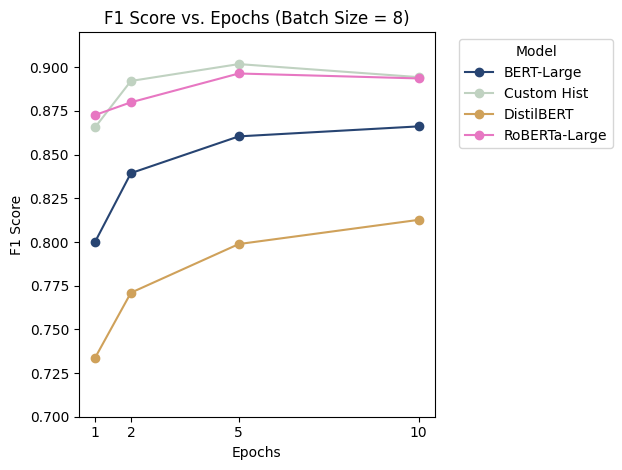

In [3]:
# Plot adjusted y-axis limits
colors = ['#274472', '#C0D2C1', '#CFA15A', '#E777C2']
plt.figure(figsize=(8, 5))
pivot_df.plot(marker='o', color=colors)
plt.title(f'F1 Score vs. Epochs (Batch Size = {fixed_batch_size})')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.xticks(epoch_choices)
plt.ylim(0.7, 0.92)
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()